# PREDICTIVE POLICY
By Theo Botella
### Given a time and a location predict the Category of the crime commited in the city of the Bay

In [77]:
#imports
from geopy.geocoders import Nominatim
from sklearn import preprocessing 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Data Exploration

In [78]:
train = pd.read_csv('train.csv')

In [79]:
train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [80]:
#WHAT WE WANT TO PREDICT
print(train.Category.unique())
len(train.Category.unique())

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


39

# Data Preprocessing

## Cleaning
* Duplicates
* Smooth noisy data (erros, outliers)

In [81]:
#Remove duplicates
train = train.drop_duplicates()
len(train)

875726

#### We removed 2323 duplicates from the dataset

In [ ]:
#Remove bad cordinates (errors and outliers)
#X<-121 and Y<40 to target San Francisco County
train['X'] = train[train.X<-121].X
train['Y'] = train[train.Y<40].Y
#Remove NA (missing data)
train = train.dropna()

#### We removed 67 bad cordinates and NA, our dataset is now of size 875,659

In [83]:
len(train)

875659

# Feature Engineering

#### Select Categories to predict
* Re-balance the dataset
* Select Categories representing 80% of the crimes
* Remove unwanted categories  

#### Create new features 
* From the ‘Dates’ field, we extracted the Day, the Month, the Year, the Hour, the Minute.
* From ‘Address’ field we extracted if the incident has taken place in a crossroad or on a building block (boolean 'Block').
* Cluster crimes position to improve prediction using the district - some districts are closely associated with certain crimes (e.g. Mission district and drug).

## Select Categories to predict

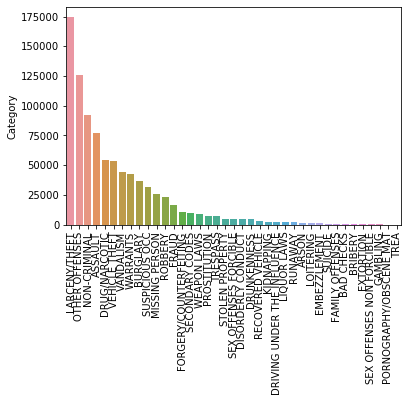

In [84]:
number_of_crimes = train.Category.value_counts()

_n_crime_plot = sns.barplot(x=number_of_crimes.index,y=number_of_crimes)
_n_crime_plot = _n_crime_plot.set_xticklabels(number_of_crimes.index,rotation=90)

### PROBLEM: UMBALANCED DATASET

### Resample the dateset

In [85]:
def resample_dataset(category, n_samples, dataset):
   
    #Select all data of the category
    category_data = dataset[dataset.Category == category]
    
    #Randomly select n_samples of the data for this category
    category_resampled = resample(category_data, n_samples=n_samples, replace=False, random_state=0)
    
    #Create new df without the data of the category
    drop_data_cate = dataset[dataset.Category != category]
    
    #Add the n_samples data to the new df 
    balanced_train = drop_data_cate.append(category_resampled)
    
    #Suffle the rows (frac=1) before returning the re_sampled dataset 
    train = balanced_train.sample(frac=1).reset_index(drop=True)
    
    return train

In [86]:
train = resample_dataset('LARCENY/THEFT', 55000, train)
train = resample_dataset('NON-CRIMINAL', 55000, train)
train = resample_dataset('OTHER OFFENSES', 55000, train)
train = resample_dataset('ASSAULT', 55000, train)

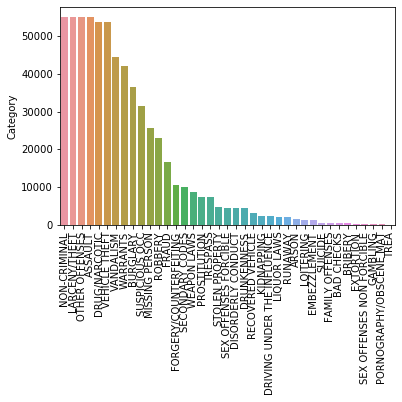

In [87]:
number_of_crimes = train.Category.value_counts()

_n_crime_plot = sns.barplot(x=number_of_crimes.index,y=number_of_crimes)
_n_crime_plot = _n_crime_plot.set_xticklabels(number_of_crimes.index,rotation=90)

## Select Categories to predict

### Categories representing 80% of the crimes

In [88]:
def select_cate(number_of_crimes):
    pourcent_crimes = round(len(train)*0.80)
    cate = []
    crime_count = 0
    for crime in range(len(number_of_crimes)):
        if (crime_count < pourcent_crimes):
            cate.append(number_of_crimes.index[crime])
            crime_count += number_of_crimes[crime]
        
    return cate

In [89]:
cate_maj_crime = select_cate(number_of_crimes)
cate_maj_crime

['NON-CRIMINAL',
 'LARCENY/THEFT',
 'OTHER OFFENSES',
 'ASSAULT',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'VANDALISM',
 'WARRANTS',
 'BURGLARY',
 'SUSPICIOUS OCC',
 'MISSING PERSON']

### Remove not usefull category (the ones the prediction won't help the police and the minor crimes)


In [90]:
#No sens to predict the crime is an 'other offenses'
cate_maj_crime.remove('OTHER OFFENSES')
#Focusing on criminal crimes
cate_maj_crime.remove('NON-CRIMINAL')
#Suspicious activity report does not mean a lot
cate_maj_crime.remove('SUSPICIOUS OCC')
#Warrants are arrestations, no points to predict them 
cate_maj_crime.remove('WARRANTS')
cate_maj_crime

['LARCENY/THEFT',
 'ASSAULT',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'VANDALISM',
 'BURGLARY',
 'MISSING PERSON']

In [91]:
df = train.loc[train['Category'].isin(cate_maj_crime)]

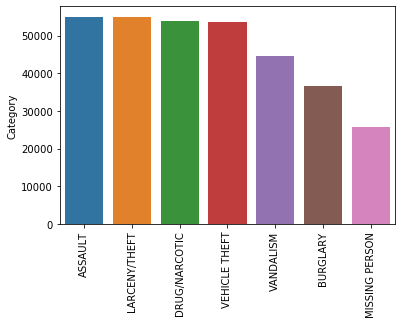

In [92]:
number_of_crimes = df.Category.value_counts()

_n_crime_plot = sns.barplot(x=number_of_crimes.index,y=number_of_crimes)
_n_crime_plot = _n_crime_plot.set_xticklabels(number_of_crimes.index,rotation=90)

### We now have a more balance dataset. We will try to predict, given a time and a location, which one of these 7 categories the crime belongs to. 

## Data Transformation
* One Hot Encoding (change categorical values into numbers)

In [ ]:
#Day of Week
days_dict = {'Monday': 1,
             'Tuesday': 2,
             'Wednesday': 3,
             'Thursday': 4,
             'Friday': 5,
             'Saturday': 6,
             'Sunday': 7}
df["DayOfWeek"] = df["DayOfWeek"].replace(days_dict)

In [94]:
#Categories into numbers
cate_dict =      {'ASSAULT':1,
                  'LARCENY/THEFT':2,
                  'DRUG/NARCOTIC':3,
                  'VEHICLE THEFT':4,
                  'VANDALISM':5,
                  'BURGLARY':6,
                  'MISSING PERSON':7
                 }
#df["Category"] = df["Category"].replace(cate_dict)

In [ ]:
#PdDistric into numbers
districts = df['PdDistrict'].unique()
districts_dict = {}
count = 1

for d in districts:
    districts_dict[d] = count
    count+=1

df['PdDistrict']=df['PdDistrict'].replace(districts_dict)

## Create New Features

In [ ]:
df['Dates'] = df['Dates'].astype('datetime64[ns]') 

In [ ]:
#Create Day, Month, Year, Hour, Minute features
df['year'] = df['Dates'].dt.year 
df['month'] = df['Dates'].dt.month 
df['day'] = df['Dates'].dt.day 
df['hour'] = df['Dates'].dt.hour 
df['minute'] = df['Dates'].dt.minute 

In [ ]:
#Create the boolean 'Block' to know if the incident has taken place in a building block or in a croosroad (outside) 
df['Block'] = df.apply(lambda x: 1 
                             if 'Block' in x['Address'] 
                             else 0, axis=1)

### CLUSTERING using K-MEANS
* Add new feature: CLUSTER - using location information only
* Group crimes depending on their location (Mission District = Drug/Narcotic?)

### We want 7 clusters as it is the number of Categories to predict
#### We hope each cluster will represent one category (Mission District = Drug/Narcotic)

In [99]:
#K-MEANS
df_cluster = df[['PdDistrict','Block','X','Y']]
kmeans = KMeans(n_clusters=7, random_state=1).fit_predict(df_cluster)

In [ ]:
#Add Cluster feature to our dataset
df['Cluster'] = kmeans

#### Drop unused columns of the dataset - we want K-means to use only location information

In [101]:
df_train = df.drop(columns=['Dates','Descript', 'Resolution','Address', 'year','day','minute'])

In [102]:
df_train

,Category,DayOfWeek,PdDistrict,X,Y,month,hour,Block,Cluster
0,MISSING PERSON,5,1,-122.464045,37.761316,8,16,1,3
2,VANDALISM,4,2,-122.409854,37.783386,2,6,1,3
5,VEHICLE THEFT,2,3,-122.419416,37.775905,9,0,0,1
11,ASSAULT,4,1,-122.453535,37.769166,8,16,0,3
14,MISSING PERSON,3,1,-122.462886,37.760084,7,5,1,3
...,...,...,...,...,...,...,...,...,...
626674,VEHICLE THEFT,4,6,-122.435041,37.726203,4,23,1,6
626678,LARCENY/THEFT,6,8,-122.475647,37.728528,3,13,1,2
626679,VEHICLE THEFT,5,5,-122.455714,37.783977,4,12,0,5
626680,VANDALISM,5,8,-122.508936,37.757470,1,2,1,2


=====================================================================================================================

## The goal of the project is to predict, given a time and a location, the type of crime.
### Here is the list of the Crime Categories:
* ASSAULT
* LARCENY/THEFT
* DRUG/NARCOTIC
* VEHICLE THEFT
* VANDALISM
* BULGARY
* MISSING PERSON

=====================================================================================================================

### SAVE AND USE CLEAN DATASET

In [103]:
#Save dataset
df_train.to_csv(r'df_train.csv')

In [104]:
#Trainset with numerical values
train_num = pd.read_csv('df_train.csv')
train_num = train_num.drop(train_num.columns[0], axis=1)

In [105]:
train_num.head()

,Category,DayOfWeek,PdDistrict,X,Y,month,hour,Block,Cluster
0,MISSING PERSON,5,1,-122.464045,37.761316,8,16,1,3
1,VANDALISM,4,2,-122.409854,37.783386,2,6,1,3
2,VEHICLE THEFT,2,3,-122.419416,37.775905,9,0,0,1
3,ASSAULT,4,1,-122.453535,37.769166,8,16,0,3
4,MISSING PERSON,3,1,-122.462886,37.760084,7,5,1,3


### Correlation Matrix

In [106]:
df_corr = pd.DataFrame(train_num,columns=['Category','DayOfWeek','PdDistrict','X','Y','hour','Block','Cluster'])
df_corr["Category"] = df_corr["Category"].replace(cate_dict)
corr = df_corr.corr(method ='pearson')

#Correlation Matrix with Category as the target
print(corr['Category'])

Category      1.000000
DayOfWeek    -0.011073
PdDistrict   -0.021964
X            -0.084586
Y            -0.101540
hour         -0.006871
Block         0.152325
Cluster       0.080822
Name: Category, dtype: float64


# Data Visualization
## Distribution
* Nb of Crimes per day (Normal distribution ?)
* Distribution Crimes per day
* Nb Crimes per Category

## Features
* Police districts bondaries on map
* Density of Crimes per Category
* Number of Crimes per Category depending on Time/Hour

### Days at which crimes occur

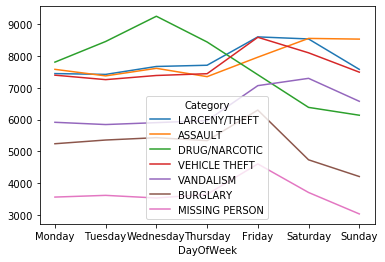

In [107]:
tmp = train.loc[:,["DayOfWeek","Category"]]
pt = pd.pivot_table(tmp,index="DayOfWeek",columns="Category",aggfunc=len,fill_value=0)
pt.loc[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],cate_maj_crime].plot()

#### Surprisingly, there is no more crimes the weekends than during the week

### Hours at which crimes occur through days

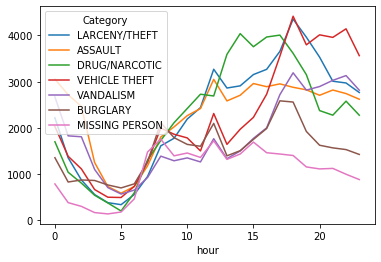

In [108]:
tmp = train_num.loc[:,["hour","Category"]]
pt = pd.pivot_table(tmp,index="hour",columns="Category",aggfunc=len,fill_value=0)
pt.loc[:,cate_maj_crime].plot()

#### Crimes tend to append during the day to meet a peak between 5pm to 7pm 

### Visualization using SF map

In [109]:
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

### Compare location of clusters with categories

In [110]:
tmp_train = pd.DataFrame(train_num,columns=['Category','Cluster'])

In [111]:
#Clusters = all clusters from 0 to 6
clusters = tmp_train['Cluster'].unique()
all_clust_cate = []
for c in clusters:
    clust_cate = []
    for i in range(len(tmp_train)):
        if(tmp_train['Cluster'][i] == c):
            clust_cate.append(tmp_train['Category'][i])
    all_clust_cate.append(clust_cate)

#clust_cate = the category of the point belonging to cluster c
#all_clust_cate = cluster 0: all the categories of each points of cluster 0
#                 cluster 1: all the categories of each points of cluster 1...

In [112]:
clusters = tmp_train['Cluster'].unique()
clusters.sort()
clust_cate = {}

for c in clusters:
    lst = all_clust_cate[c]
    clust_cate[str(c)] = max(lst,key=lst.count)

In [113]:
clust_cate

{'0': 'DRUG/NARCOTIC',
 '1': 'LARCENY/THEFT',
 '2': 'VEHICLE THEFT',
 '3': 'VEHICLE THEFT',
 '4': 'LARCENY/THEFT',
 '5': 'ASSAULT',
 '6': 'DRUG/NARCOTIC'}

- Cluster 0 is mainly represented by DRUG/NARCOTIC crimes.
- We will now visualize where the data points of Cluster 0 are located.
- If it's in Mission District that would mean our clustering is working well and the *Cluster* feature is adding value. 

### Visualizing Categories on MAP

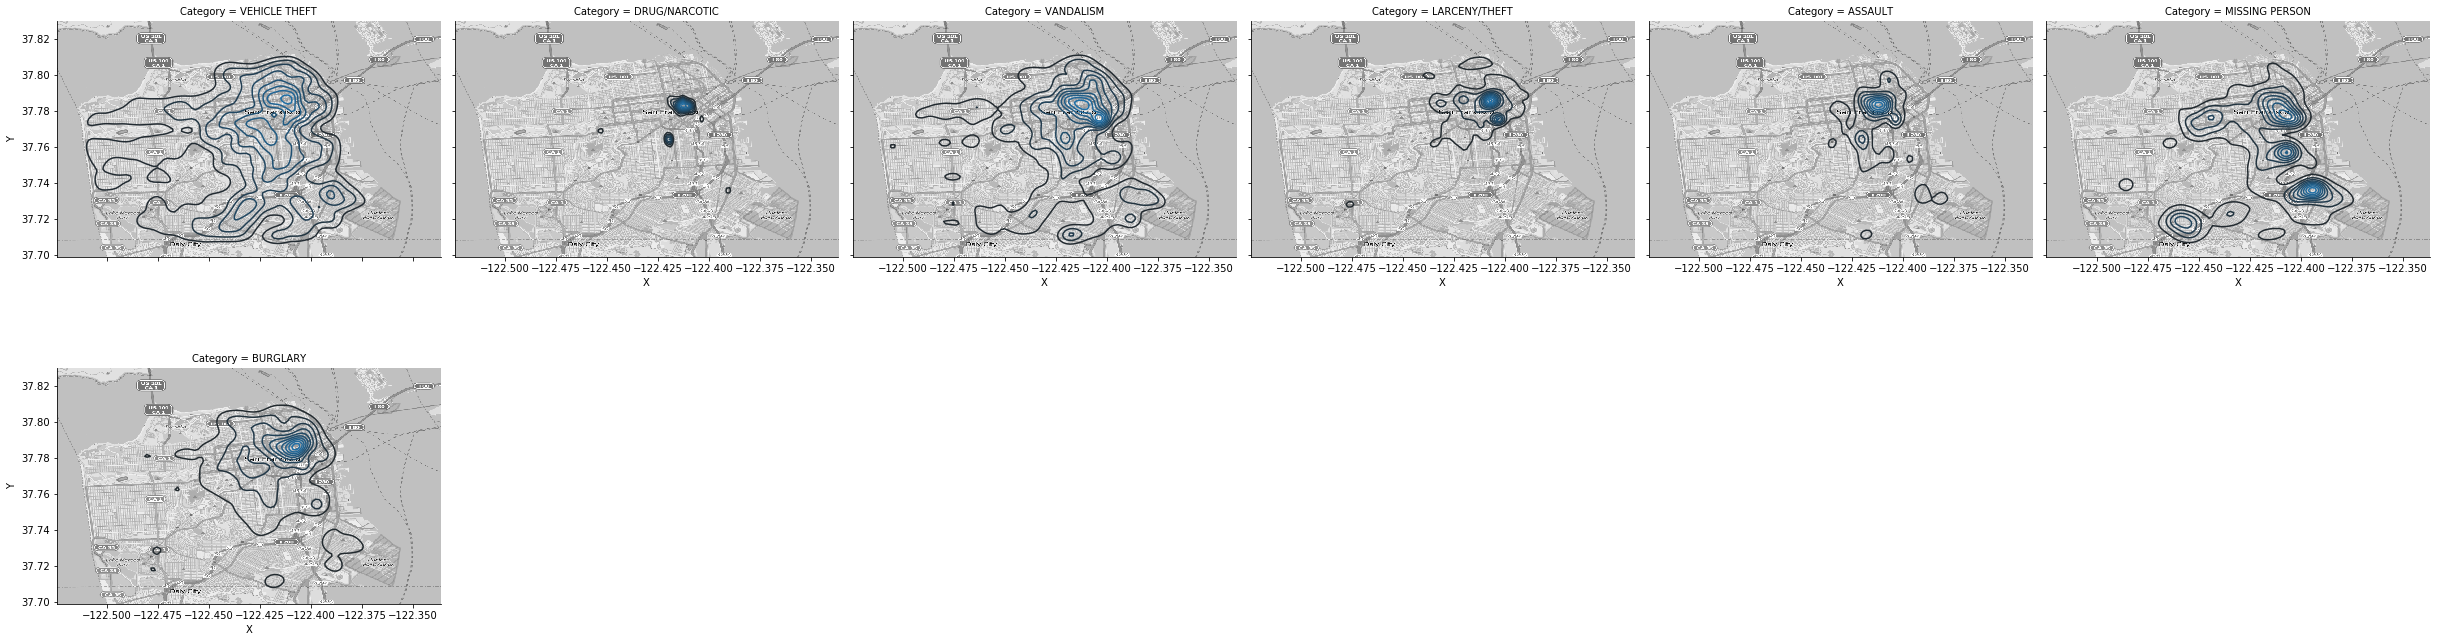

In [55]:
#Seaborn FacetGrid, split by crime Category
g= sns.FacetGrid(train_num, col="Category", col_wrap=6, height=5, aspect=1/asp)

#Show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
#Kernel Density Estimate plot
g.map(sns.kdeplot, "X", "Y", clip=clipsize)
plt.savefig('map_cate.png')

- Most of the crimes in San Francisco occur in Mission District, Tenderloin or in the Financial District
- VEHICLE THEFT and VANDALISM take place everywhere whereas DRUG/NARCOTIC are specifically located in Tenderloin and Mission  

### Visualizing Clusters on MAP

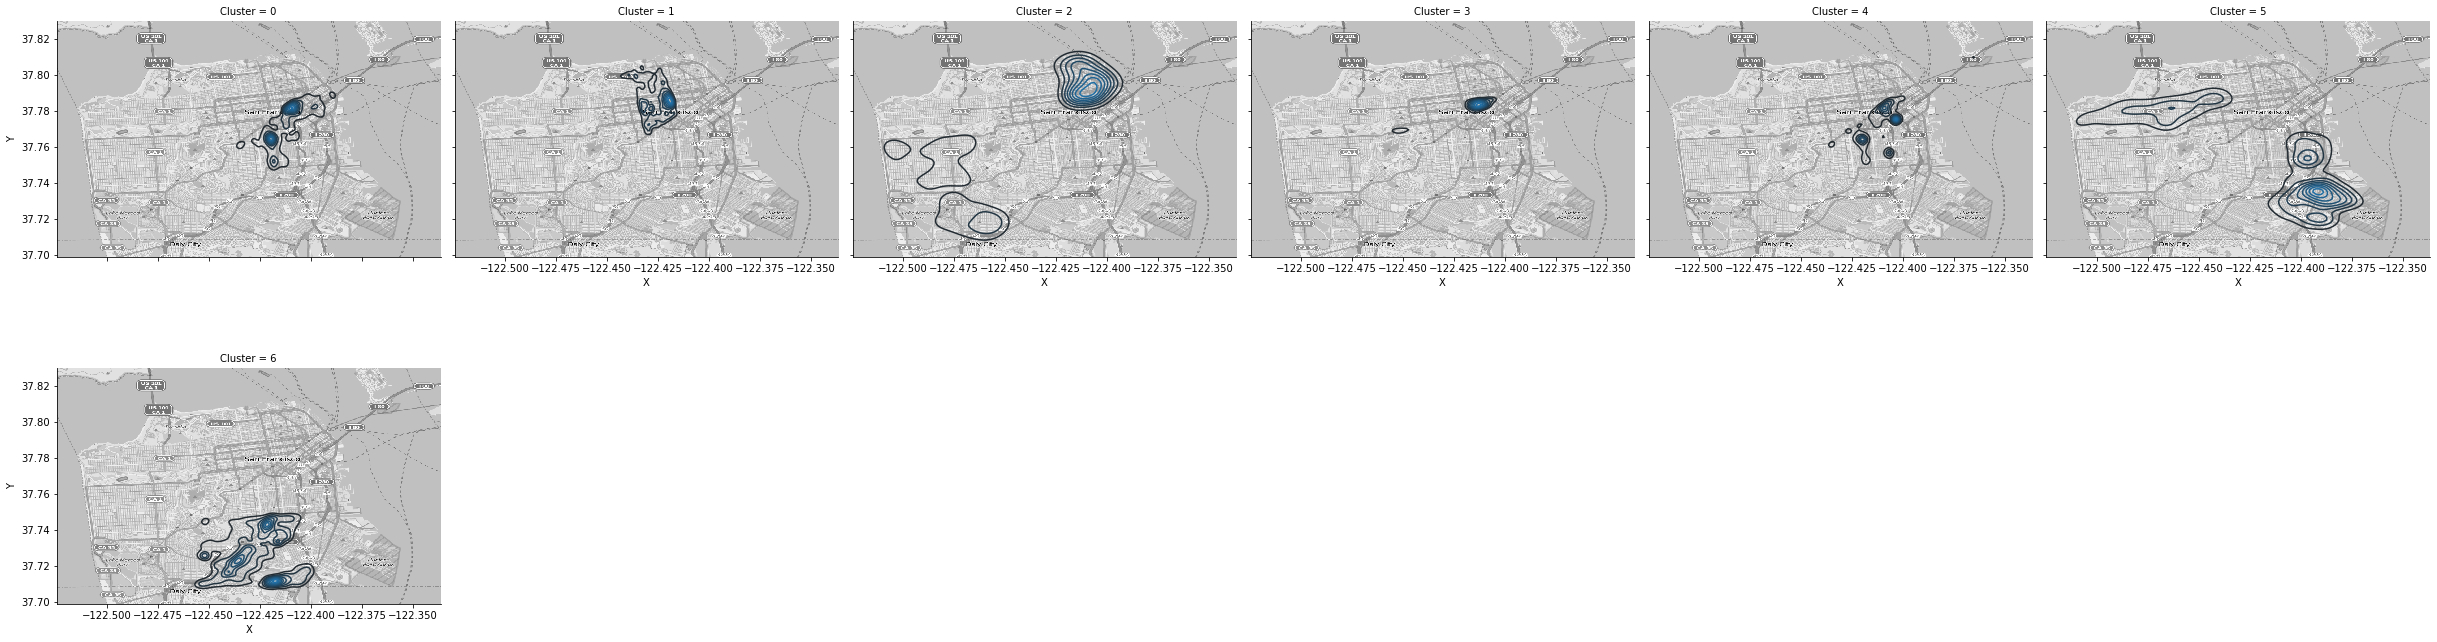

In [114]:
#Seaborn FacetGrid, split by crime Cluster
g= sns.FacetGrid(train_num, col="Cluster", col_wrap=6, height=5, aspect=1/asp)

#Show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
#Kernel Density Estimate plot
g.map(sns.kdeplot, "X", "Y", clip=clipsize)
plt.savefig('map_cluster.png')

### Let's compare both MAPS

# Categories
![im.index](map_cate.png)
# Clusters
![im.index](map_cluster.png)


- Cluster 0 has a majority of data points representing DRUG/NARCOTIC crimes.
- We can see that it is targeting Mission District and Tenderloin. 
- Clustering using location info, we can get some insight about what type of crime is happening in which district. We will use this Cluster number as one of the important features in our classification models 

# Building Models 
## Using ScikitLearn classification models 
https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/

* ~~(PCA / Non Linear PCA)~~
* K Nearest Neighbors
* Logistic Regression
* ~~Naives Bayes~~
* Decision Tree
* LDA
* Neural Networks
* ~~SVM~~
* Random Forest


#### Accuracy function

In [115]:
def accuracy_model(test_labels, predictions_model):
    accuracy = round(sum(test_labels == predictions_model)/len(test_labels),2)
    return accuracy

### K-Neirest Neighbors

In [116]:
def knn_model():   
    knn = KNeighborsClassifier(n_neighbors=25)
    knn_trained = knn.fit(training_data, training_labels)
    predictions_knn = knn_trained.predict(test_data)

    accuracy_knn = accuracy_model(test_labels, predictions_knn)
    return accuracy_knn

### LOGISTIC REGRESSION

In [117]:
def log_model():
    log = LogisticRegression()
    log.fit(training_data, training_labels)
    predictions_log = log.predict(test_data)

    accuracy_log = accuracy_model(test_labels, predictions_log)
    return accuracy_log

### DECISION TREE

In [118]:
def tree_model():
    model_tree = tree.DecisionTreeClassifier()
    model_tree.fit(training_data, training_labels)
    predictions_tree = model_tree.predict(test_data)

    accuracy_tree = accuracy_model(test_labels, predictions_tree)
    return accuracy_tree

### LINEAR DISCRIMINANT ANALYSIS

In [119]:
def LDA_model():
    model_LDA = LinearDiscriminantAnalysis()
    model_LDA.fit(training_data, training_labels)
    predictions_LDA = model_LDA.predict(test_data)

    accuracy_LDA = accuracy_model(test_labels, predictions_LDA)
    return accuracy_LDA

### NEURAL NETWORK (SUPERVISED)

In [120]:
def nn_model():
    model_net =  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    model_net.fit(training_data, training_labels)
    predictions_net = model_net.predict(test_data)

    accuracy_net = accuracy_model(test_labels, predictions_net)
    return accuracy_net

### RANDOM FOREST

In [121]:
def rf_model():
    # Create the model with 100 trees
    model = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    # Fit on training data
    model.fit(training_data, training_labels)

    # Actual class predictions
    rf_predictions = model.predict(test_data)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_data)[:, 1]

    accuracy_rf = accuracy_model(test_labels, rf_predictions)
    return (accuracy_rf, rf_predictions)

# Model Evaluation and Selection

In [122]:
#train_test_split
features = ["DayOfWeek", "PdDistrict",  "X", "Y","hour",'Block','Cluster']
(training_data, test_data, training_labels, test_labels) = train_test_split(train_num[features], train_num['Category'], test_size=0.2)

def compare_models():
    accuracies = {}
    
    #KNN
    #acc_knn = knn_model()
    accuracies['KNN          '] = knn_model()
    #Log Reg
    #acc_log = log_model()
    accuracies['Logistic Reg '] = log_model()
    #Decision Tree
    #acc_tree = tree_model()
    accuracies['Decision Tree'] = tree_model()
    #LDA
    #acc_LDA = LDA_model()
    accuracies['LDA          '] = LDA_model()
    #Neural Net
    #acc_nn = nn_model()
    accuracies['Neural Net   '] = nn_model()
    #Random Forest
    #acc_rf = rf_model()
    accuracies['Random Forest'] = rf_model()[0]
    
    return accuracies

In [123]:
def print_models_acc():     
    #Get accuracies of all models
    accuracies_models = compare_models()
    
    print('''======================================\n===========MODEL EVALUATION===========\n======================================\n========ACCURACIES COMPARAISON========\n======================================\n''')
    
    #Sort and return the accuracies in Descending order
    acc = list(sorted(accuracies_models.items(), key=lambda x: x[1], reverse=True))
    for i in range(len(acc)):
        print(str(acc[i][0]) + ' : ' + str(acc[i][1]))
    
    return

In [129]:
print_models_acc()

C:\Users\theo0\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


===========MODEL EVALUATION===========
========ACCURACIES COMPARAISON========

Random Forest : 0.43
Decision Tree : 0.41
KNN           : 0.33
LDA           : 0.26
Logistic Reg  : 0.24
Neural Net    : 0.17


## The most performing algorithm is RANDOM FOREST: accuracy =  0.43
## We select the RANDOM FOREST Model as the final model for Predictive Policy
### We will now go deeper into the analysis of this model

### Random Forest model

In [125]:
#train_test_split
features = ["DayOfWeek", "PdDistrict",  "X", "Y","hour",'Block','Cluster']
(training_data, test_data, training_labels, test_labels) = train_test_split(train_num[features], train_num['Category'], test_size=0.2)

rf = rf_model()
rf_predictions = rf[1]

### Confusion Matrix

In [126]:
def conf_mat(y_true, y_pred):
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)
    return conf_mat

In [127]:
conf_mat(test_labels,rf_predictions)

array([[[46862,  7128],
        [ 7265,  3638]],

       [[52582,  4904],
        [ 5124,  2283]],

       [[49836,  4229],
        [ 3420,  7408]],

       [[46935,  6817],
        [ 7025,  4116]],

       [[57957,  1863],
        [ 2156,  2917]],

       [[50480,  5516],
        [ 7151,  1746]],

       [[47827,  6422],
        [ 4738,  5906]]], dtype=int64)

## Classification Report

#### Precision: Among all crimes predicted as 'VEHICLE THEFT', what is the ratio that is was indeed a 'VEHICLE THEFT'

In [128]:
print(classification_report(test_labels, rf_predictions, target_names=['VEHICLE THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 'LARCENY/THEFT','ASSAULT', 'BURGLARY','MISSING PERSON']))

                precision    recall  f1-score   support

 VEHICLE THEFT       0.34      0.33      0.34     10903
 DRUG/NARCOTIC       0.32      0.31      0.31      7407
     VANDALISM       0.64      0.68      0.66     10828
 LARCENY/THEFT       0.38      0.37      0.37     11141
       ASSAULT       0.61      0.58      0.59      5073
      BURGLARY       0.24      0.20      0.22      8897
MISSING PERSON       0.48      0.55      0.51     10644

      accuracy                           0.43     64893
     macro avg       0.43      0.43      0.43     64893
  weighted avg       0.42      0.43      0.43     64893



## Finally, it seems our model is quite good to predict: 'VANDALISM' and 'ASSAULT' crimes

### IMPROVMENTS
#### Here, we assume the crime belongs to one of the 7 categories. 
* In real-life, or at least for this dataset, the number of crime category is 39 ! 
* To improve our model, keeping only 7 categories to predict, we should add the prediction 'None of the 7'

#### We can then
- COMPUTE A PROBABILITY FOR EACH CRIME
- PREDICT IF YES OR NO IT IS A SPECIFIC CRIME
- RETURN THE BIGGEST PROBABILITY AS THE PREDICTION